In [3]:
# yet another notebook just playing around.


In [5]:
import matplotlib.pyplot as plt     # allows creation of insightful plots
import numpy as np                  # for performing calculations on numerical arrays
import pandas as pd                 # home of the DataFrame construct, _the_ most important object for Data Science
import seaborn as sns               # allows creation of insightful plots, but a bit prettier
import sys                          # Python system library needed to load custom functions
import torchaudio                   # library that will allow us to load the audio files
import os                           # for changing the directory

from scipy.fft import fft, fftfreq  # functions for calculating the fourier transform and frequencies from audio data
from tqdm.auto import tqdm          # library to display progress bar while doing apply on pandas dataframe

sys.path.append('../../src')
pd.set_option('display.max_columns', None) # All the columns in a dataframe are shown 
tqdm.pandas()                       # integrate tqdm with Pandas
# line to render the plots under the code cell that created it
%matplotlib inline

from eda_utils import plot_spec     # functions to create plots for and from audio data
from gdsc_utils import PROJECT_DIR # our root directory
os.chdir(PROJECT_DIR) # changing our directory to root

In [9]:
df_metadata = pd.read_csv('data/metadata.csv') # loading the metadata file
example_path = df_metadata.loc[0, 'path'] # getting the first path from the dataset
example_path

'data/train/Roeselianaroeselii_XC751814-dat028-019_edit1.wav'

In [11]:
df_metadata['species and label'] = df_metadata.apply(lambda x: f"{x['species']} ({str(x['label'])})", axis = 1)

In [13]:
df_metadata

,file_name,unique_file,path,species,label,subset,sample_rate,num_frames,length,species and label
0,Roeselianaroeselii_XC751814-dat028-019_edit1.wav,Roeselianaroeselii_XC751814-dat028-019,data/train/Roeselianaroeselii_XC751814-dat028-...,Roeselianaroeselii,56,train,44100,4586400,104.000000,Roeselianaroeselii (56)
1,Roeselianaroeselii_XC752367-dat006-010.wav,Roeselianaroeselii_XC752367-dat006-010,data/train/Roeselianaroeselii_XC752367-dat006-...,Roeselianaroeselii,56,train,44100,337571,7.654671,Roeselianaroeselii (56)
2,Yoyettacelis_GBIF2465208563_IN36000894_50988.wav,Yoyettacelis_GBIF2465208563_IN36000894_50988,data/train/Yoyettacelis_GBIF2465208563_IN36000...,Yoyettacelis,64,train,44100,220500,5.000000,Yoyettacelis (64)
3,Gomphocerippusrufus_XC752285-dat001-045.wav,Gomphocerippusrufus_XC752285-dat001-045,data/train/Gomphocerippusrufus_XC752285-dat001...,Gomphocerippusrufus,26,train,44100,693715,15.730499,Gomphocerippusrufus (26)
4,Atrapsaltacorticina_GBIF2901504947_IN62966536_...,Atrapsaltacorticina_GBIF2901504947_IN62966536_...,data/val/Atrapsaltacorticina_GBIF2901504947_IN...,Atrapsaltacorticina,3,validation,44100,502740,11.400000,Atrapsaltacorticina (3)
...,...,...,...,...,...,...,...,...,...,...
2326,Conocephalusdorsalis_XC752036-dat004-002.wav,Conocephalusdorsalis_XC752036-dat004-002,data/train/Conocephalusdorsalis_XC752036-dat00...,Conocephalusdorsalis,16,train,44100,7668144,173.880816,Conocephalusdorsalis (16)
2327,Pseudochorthippusmontanus_XC752605-dat012-003_...,Pseudochorthippusmontanus_XC752605-dat012-003,data/train/Pseudochorthippusmontanus_XC752605-...,Pseudochorthippusmontanus,54,train,44100,573300,13.000000,Pseudochorthippusmontanus (54)
2328,Pholidopteralittoralis_XC752439-dat049-001_edi...,Pholidopteralittoralis_XC752439-dat049-001,data/train/Pholidopteralittoralis_XC752439-dat...,Pholidopteralittoralis,44,train,44100,88200,2.000000,Pholidopteralittoralis (44)
2329,Gomphocerussibiricus_XC751796-dat187-005_edit2...,Gomphocerussibiricus_XC751796-dat187-005,data/train/Gomphocerussibiricus_XC751796-dat18...,Gomphocerussibiricus,27,train,44100,1190700,27.000000,Gomphocerussibiricus (27)


In [16]:
kingdom_df = pd.read_csv(f'exploratory_notebooks/gsk/input_data/data_for_augmentation.csv')
kingdom_df

,RN,species and label,Method,Common Name,Order:,Suborder:,Family:,Genus:,Species:,Species (GSK)
0,3,Atrapsaltacollina (2),Tymbals,NaN,Hemiptera,Auchenorrhyncha,Cicadidae,Atrapsalta,NaN,Atrapsalta collina
1,4,Atrapsaltacorticina (3),Tymbals,NaN,Hemiptera,Auchenorrhyncha,Cicadidae,Atrapsalta,NaN,Atrapsalta corticina
2,5,Atrapsaltaencaustica (4),Tymbals,NaN,Hemiptera,Auchenorrhyncha,Cicadidae,Atrapsalta,NaN,Atrapsalta encaustica
3,2,Aleetacurvicosta (1),Tymbals,Floury Baker,Hemiptera,Auchenorrhyncha,Cicadidae,Cicadettinae,Lamotialnini,Aleeta curvicosta
4,21,Diceroproctaeugraphica (20),Tymbals,NaN,Hemiptera,Auchenorrhyncha,Cicadidae,Diceroprocta,D. eugraphica,Diceroprocta eugraphica
...,...,...,...,...,...,...,...,...,...,...
61,58,Ruspolianitidula (57),Stridulation,NaN,Orthoptera,Ensifera,Tettigoniidae,Ruspolia,R. nitidula,Ruspolia nitidula
62,62,Tettigoniacantans (61),Stridulation,NaN,Orthoptera,Ensifera,Tettigoniidae,Tettigonia,T. cantans,Tettigonia cantans
63,63,Tettigoniaviridissima (62),Stridulation,Great green bush-cricket,Orthoptera,Ensifera,Tettigoniidae,Tettigonia,T. viridissima,Tettigonia viridissima
64,64,Tylopsislilifolia (63),Stridulation,lily bush-cricket,Orthoptera,Ensifera,Tettigoniidae,Tylopsis,T. lilifolia,Tylopsis lilifolia


In [35]:
# This cell might be broken, as ran out of order
df_metadata=pd.merge(df_metadata,kingdom_df, left_on='species and label', right_on='species and label')
df_metadata

,file_name,unique_file,path,species,label,subset,sample_rate,num_frames,length,species and label,top_frequency,RN,Method,Common Name,Order:,Suborder:,Family:,Genus:,Species:,Species (GSK)
0,Roeselianaroeselii_XC751814-dat028-019_edit1.wav,Roeselianaroeselii_XC751814-dat028-019,data/train/Roeselianaroeselii_XC751814-dat028-...,Roeselianaroeselii,56,train,44100,4586400,104.000000,Roeselianaroeselii (56),21681.400000,57,Stridulation,Roesel's bush-cricket,Orthoptera,Ensifera,Tettigoniidae,Roeseliana,R. roeselii,Roeseliana roeselii
1,Roeselianaroeselii_XC752367-dat006-010.wav,Roeselianaroeselii_XC752367-dat006-010,data/train/Roeselianaroeselii_XC752367-dat006-...,Roeselianaroeselii,56,train,44100,337571,7.654671,Roeselianaroeselii (56),14937.023026,57,Stridulation,Roesel's bush-cricket,Orthoptera,Ensifera,Tettigoniidae,Roeseliana,R. roeselii,Roeseliana roeselii
2,Roeselianaroeselii_XC751812-dat025-010_edit1.wav,Roeselianaroeselii_XC751812-dat025-010,data/train/Roeselianaroeselii_XC751812-dat025-...,Roeselianaroeselii,56,train,44100,176400,4.000000,Roeselianaroeselii (56),15512.250000,57,Stridulation,Roesel's bush-cricket,Orthoptera,Ensifera,Tettigoniidae,Roeseliana,R. roeselii,Roeseliana roeselii
3,Roeselianaroeselii_XC751813-dat028-016.wav,Roeselianaroeselii_XC751813-dat028-016,data/val/Roeselianaroeselii_XC751813-dat028-01...,Roeselianaroeselii,56,validation,44100,6536100,148.210884,Roeselianaroeselii (56),15441.000000,57,Stridulation,Roesel's bush-cricket,Orthoptera,Ensifera,Tettigoniidae,Roeseliana,R. roeselii,Roeseliana roeselii
4,Roeselianaroeselii_GBIF3355398555_IN84246142_2...,Roeselianaroeselii_GBIF3355398555_IN84246142_2...,data/train/Roeselianaroeselii_GBIF3355398555_I...,Roeselianaroeselii,56,train,44100,219979,4.988186,Roeselianaroeselii (56),14920.253751,57,Stridulation,Roesel's bush-cricket,Orthoptera,Ensifera,Tettigoniidae,Roeseliana,R. roeselii,Roeseliana roeselii
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2326,Bicoloranabicolor_XC751421-dat061-003_edit5.wav,Bicoloranabicolor_XC751421-dat061-003,data/val/Bicoloranabicolor_XC751421-dat061-003...,Bicoloranabicolor,6,validation,44100,176400,4.000000,Bicoloranabicolor (6),16441.750000,7,Stridulation,Bush Cricket,Orthoptera,Ensifera,Tettigoniidae,Bicolorana,B. bicolor,Bicolorana bicolor
2327,Bicoloranabicolor_XC752106-dat061-001_edit2.wav,Bicoloranabicolor_XC752106-dat061-001,data/train/Bicoloranabicolor_XC752106-dat061-0...,Bicoloranabicolor,6,train,44100,3087000,70.000000,Bicoloranabicolor (6),16493.200000,7,Stridulation,Bush Cricket,Orthoptera,Ensifera,Tettigoniidae,Bicolorana,B. bicolor,Bicolorana bicolor
2328,Bicoloranabicolor_XC751421-dat061-003_edit4.wav,Bicoloranabicolor_XC751421-dat061-003,data/val/Bicoloranabicolor_XC751421-dat061-003...,Bicoloranabicolor,6,validation,44100,132300,3.000000,Bicoloranabicolor (6),17776.666667,7,Stridulation,Bush Cricket,Orthoptera,Ensifera,Tettigoniidae,Bicolorana,B. bicolor,Bicolorana bicolor
2329,Bicoloranabicolor_XC751441-dat044-005.wav,Bicoloranabicolor_XC751441-dat044-005,data/train/Bicoloranabicolor_XC751441-dat044-0...,Bicoloranabicolor,6,train,44100,397715,9.018481,Bicoloranabicolor (6),20235.670015,7,Stridulation,Bush Cricket,Orthoptera,Ensifera,Tettigoniidae,Bicolorana,B. bicolor,Bicolorana bicolor


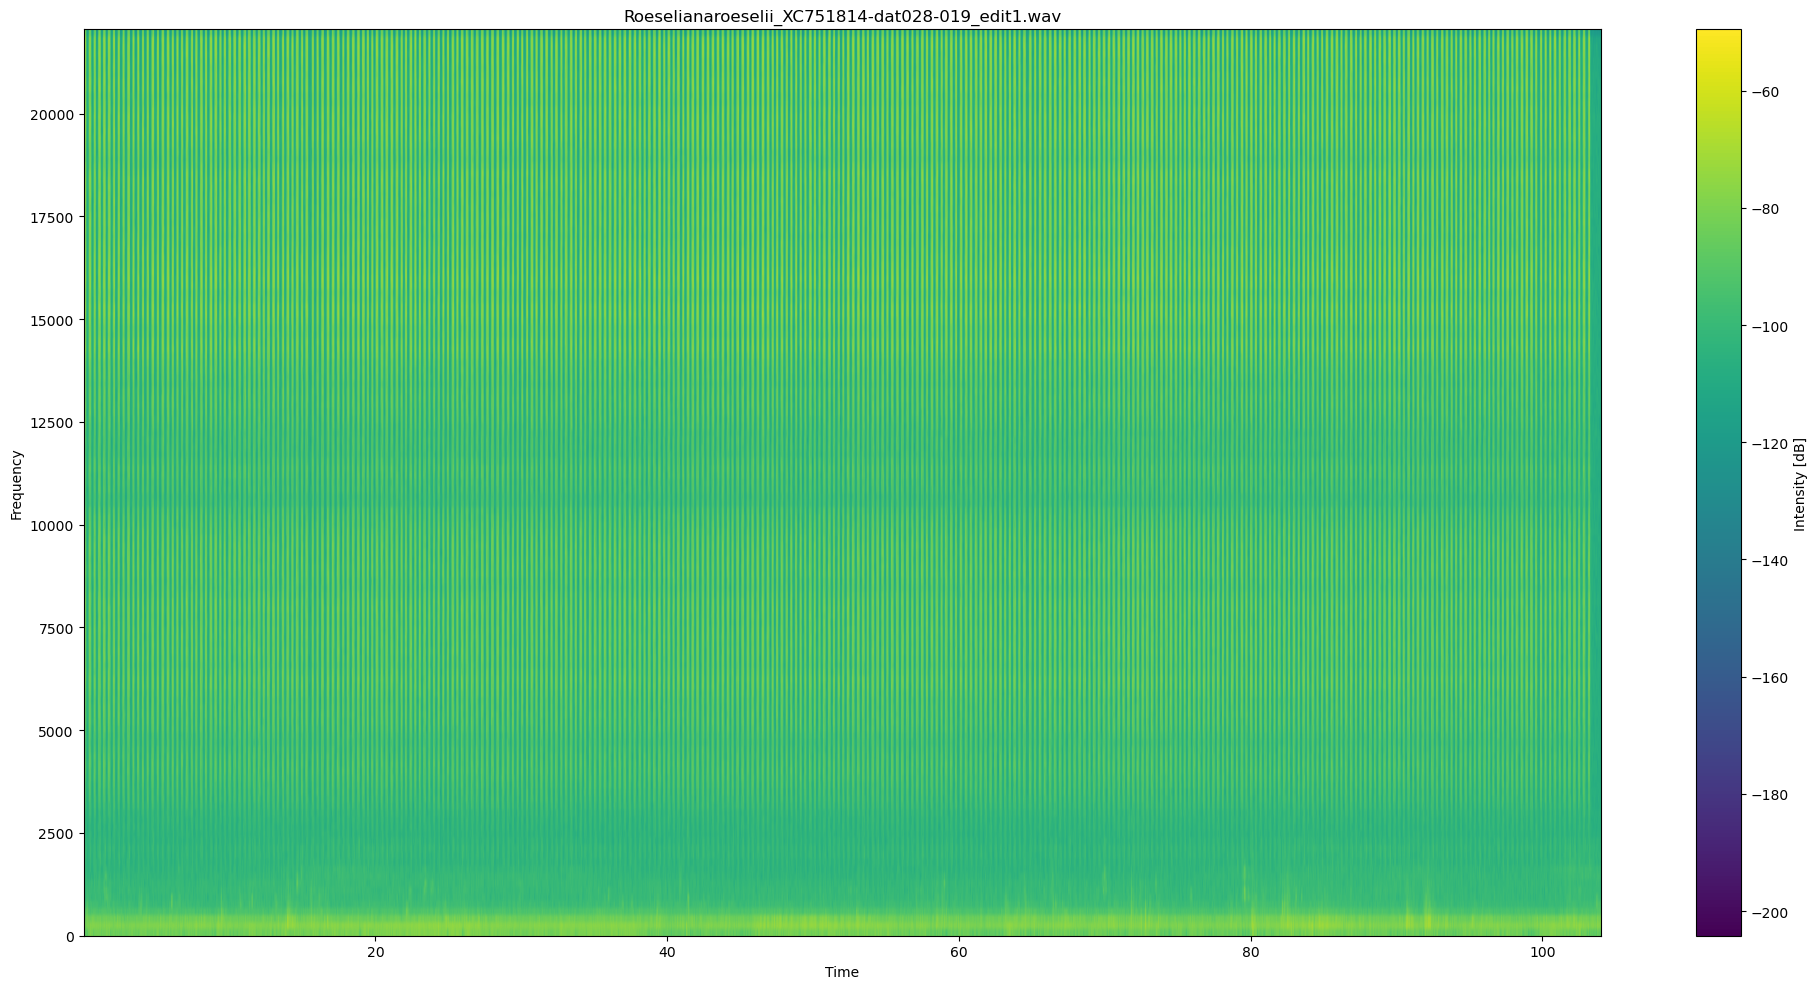

In [7]:
plot_spec([example_path])

# Try to bad model from Tutorial 3
**Goal:** trying to see if hierachical classification makes any sense. 
Lazy coding; all relevant snippets in one cell

In [18]:
def extract_peak_frequency(path, freq_threshold=300, n_top=1):
    data, sampling_rate = torchaudio.load(path)                                        # loading audio file
    data = data[0,:20*sampling_rate].numpy()                                           # Taking the first 20 seconds as it should be enough to hear insects sound
    fft_data = fft(data)                                                               # calculating fourier transform
    freqs = fftfreq(len(data))                                                         # calculating frequencies 
    freqs = abs(freqs)                                                                 # we are interested in positive numbers only
    index_above = freqs*sampling_rate>freq_threshold                                   # there is a lot of noise near 0 hz, so let's filter out what's below 300Hz, this is a hyperparameter you can play with
    peak_coefficient = np.argpartition(np.abs(fft_data[index_above]), -n_top)[-n_top:] # taking the index for top n values
    peak_freq = freqs[index_above][peak_coefficient]                                   # using the index to find top n frequencies

    return peak_freq * sampling_rate                                                   # We need to multiple it by sampling_rate to get the real frequency values

In [19]:
example_peak_freq = extract_peak_frequency(example_path, freq_threshold=300, n_top=1)
example_peak_freq

array([21681.4])

In [20]:
example_top_10_freq = extract_peak_frequency(example_path, freq_threshold=300, n_top=10)
example_top_10_freq

array([21787.5 , 21787.5 , 21512.3 , 21512.3 , 20712.4 , 21712.75,
       21681.4 , 20712.4 , 21681.4 , 21712.75])

In [21]:
# extracting top1 frequencies per file and storing it in a pandas df
df_freqs = df_metadata['path'].progress_apply(lambda x: pd.Series(extract_peak_frequency(x))) 
# joining the metadata df with the top1 frequency dataframe and renaming the column of newly created feature
df_metadata = df_metadata.join(df_freqs).rename({0:'top_frequency'}, axis = 1)

  0%|          | 0/2331 [00:00<?, ?it/s]

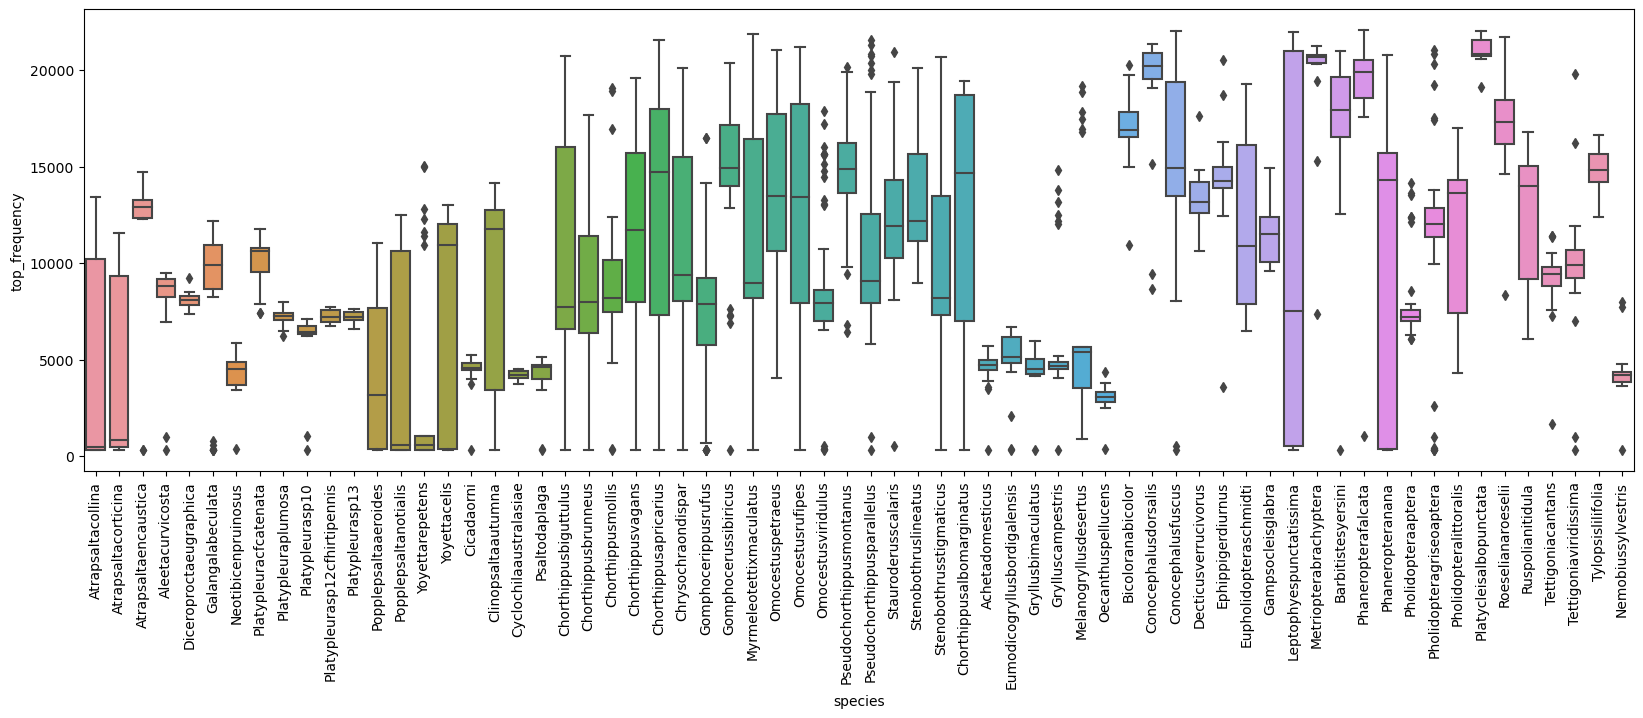

In [27]:
plt.figure(figsize = (20,6))
sns.boxplot(data = df_metadata, x = 'species', y = "top_frequency", order = [
"Atrapsaltacollina",
"Atrapsaltacorticina",
"Atrapsaltaencaustica",
"Aleetacurvicosta",
"Diceroproctaeugraphica",
"Galangalabeculata",
"Neotibicenpruinosus",
"Platypleuracfcatenata",
"Platypleuraplumosa",
"Platypleurasp10",
"Platypleurasp12cfhirtipennis",
"Platypleurasp13",
"Popplepsaltaaeroides",
"Popplepsaltanotialis",
"Yoyettarepetens",
"Yoyettacelis",
"Cicadaorni",
"Clinopsaltaautumna",
"Cyclochilaaustralasiae",
"Psaltodaplaga",
"Chorthippusbiguttulus",
"Chorthippusbrunneus",
"Chorthippusmollis",
"Chorthippusvagans",
"Chorthippusapricarius",
"Chrysochraondispar",
"Gomphocerippusrufus",
"Gomphocerussibiricus",
"Myrmeleotettixmaculatus",
"Omocestuspetraeus",
"Omocestusrufipes",
"Omocestusviridulus",
"Pseudochorthippusmontanus",
"Pseudochorthippusparallelus",
"Stauroderusscalaris",
"Stenobothruslineatus",
"Stenobothrusstigmaticus",
"Chorthippusalbomarginatus",
"Achetadomesticus",
"Eumodicogryllusbordigalensis",
"Gryllusbimaculatus",
"Grylluscampestris",
"Melanogryllusdesertus",
"Oecanthuspellucens",
"Bicoloranabicolor",
"Conocephalusdorsalis",
"Conocephalusfuscus",
"Decticusverrucivorus",
"Ephippigerdiurnus",
"Eupholidopteraschmidti",
"Gampsocleisglabra",
"Leptophyespunctatissima",
"Metriopterabrachyptera",
"Barbitistesyersini",
"Phaneropterafalcata",
"Phaneropteranana",
"Pholidopteraaptera",
"Pholidopteragriseoaptera",
"Pholidopteralittoralis",
"Platycleisalbopunctata",
"Roeselianaroeselii",
"Ruspolianitidula",
"Tettigoniacantans",
"Tettigoniaviridissima",
"Tylopsislilifolia",
"Nemobiussylvestris",
])
plt.xticks(rotation = 90)
plt.show()

In [29]:
from sklearn.ensemble import RandomForestClassifier # importing our first model from the sklearn library

In [37]:
df_metadata

,file_name,unique_file,path,species,label,subset,sample_rate,num_frames,length,species and label,top_frequency,RN,Method,Common Name,Order:,Suborder:,Family:,Genus:,Species:,Species (GSK)
0,Roeselianaroeselii_XC751814-dat028-019_edit1.wav,Roeselianaroeselii_XC751814-dat028-019,data/train/Roeselianaroeselii_XC751814-dat028-...,Roeselianaroeselii,56,train,44100,4586400,104.000000,Roeselianaroeselii (56),21681.400000,57,Stridulation,Roesel's bush-cricket,Orthoptera,Ensifera,Tettigoniidae,Roeseliana,R. roeselii,Roeseliana roeselii
1,Roeselianaroeselii_XC752367-dat006-010.wav,Roeselianaroeselii_XC752367-dat006-010,data/train/Roeselianaroeselii_XC752367-dat006-...,Roeselianaroeselii,56,train,44100,337571,7.654671,Roeselianaroeselii (56),14937.023026,57,Stridulation,Roesel's bush-cricket,Orthoptera,Ensifera,Tettigoniidae,Roeseliana,R. roeselii,Roeseliana roeselii
2,Roeselianaroeselii_XC751812-dat025-010_edit1.wav,Roeselianaroeselii_XC751812-dat025-010,data/train/Roeselianaroeselii_XC751812-dat025-...,Roeselianaroeselii,56,train,44100,176400,4.000000,Roeselianaroeselii (56),15512.250000,57,Stridulation,Roesel's bush-cricket,Orthoptera,Ensifera,Tettigoniidae,Roeseliana,R. roeselii,Roeseliana roeselii
3,Roeselianaroeselii_XC751813-dat028-016.wav,Roeselianaroeselii_XC751813-dat028-016,data/val/Roeselianaroeselii_XC751813-dat028-01...,Roeselianaroeselii,56,validation,44100,6536100,148.210884,Roeselianaroeselii (56),15441.000000,57,Stridulation,Roesel's bush-cricket,Orthoptera,Ensifera,Tettigoniidae,Roeseliana,R. roeselii,Roeseliana roeselii
4,Roeselianaroeselii_GBIF3355398555_IN84246142_2...,Roeselianaroeselii_GBIF3355398555_IN84246142_2...,data/train/Roeselianaroeselii_GBIF3355398555_I...,Roeselianaroeselii,56,train,44100,219979,4.988186,Roeselianaroeselii (56),14920.253751,57,Stridulation,Roesel's bush-cricket,Orthoptera,Ensifera,Tettigoniidae,Roeseliana,R. roeselii,Roeseliana roeselii
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2326,Bicoloranabicolor_XC751421-dat061-003_edit5.wav,Bicoloranabicolor_XC751421-dat061-003,data/val/Bicoloranabicolor_XC751421-dat061-003...,Bicoloranabicolor,6,validation,44100,176400,4.000000,Bicoloranabicolor (6),16441.750000,7,Stridulation,Bush Cricket,Orthoptera,Ensifera,Tettigoniidae,Bicolorana,B. bicolor,Bicolorana bicolor
2327,Bicoloranabicolor_XC752106-dat061-001_edit2.wav,Bicoloranabicolor_XC752106-dat061-001,data/train/Bicoloranabicolor_XC752106-dat061-0...,Bicoloranabicolor,6,train,44100,3087000,70.000000,Bicoloranabicolor (6),16493.200000,7,Stridulation,Bush Cricket,Orthoptera,Ensifera,Tettigoniidae,Bicolorana,B. bicolor,Bicolorana bicolor
2328,Bicoloranabicolor_XC751421-dat061-003_edit4.wav,Bicoloranabicolor_XC751421-dat061-003,data/val/Bicoloranabicolor_XC751421-dat061-003...,Bicoloranabicolor,6,validation,44100,132300,3.000000,Bicoloranabicolor (6),17776.666667,7,Stridulation,Bush Cricket,Orthoptera,Ensifera,Tettigoniidae,Bicolorana,B. bicolor,Bicolorana bicolor
2329,Bicoloranabicolor_XC751441-dat044-005.wav,Bicoloranabicolor_XC751441-dat044-005,data/train/Bicoloranabicolor_XC751441-dat044-0...,Bicoloranabicolor,6,train,44100,397715,9.018481,Bicoloranabicolor (6),20235.670015,7,Stridulation,Bush Cricket,Orthoptera,Ensifera,Tettigoniidae,Bicolorana,B. bicolor,Bicolorana bicolor


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision: 0.09
recall: 0.08
f1-score:0.08
accuracy: 0.11


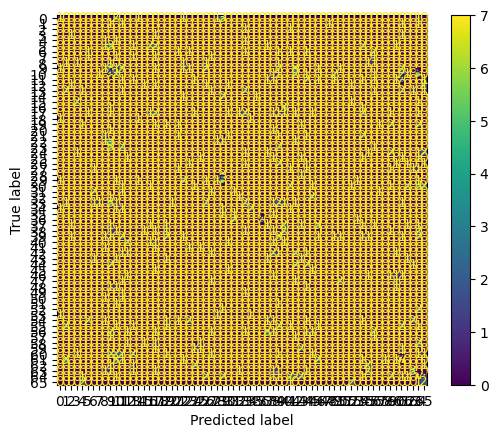

In [57]:
df_train = df_metadata[df_metadata['subset']=='train']
df_val = df_metadata[df_metadata['subset']=='validation']

#df_train = df3[df3['subset']=='train']
#df_val = df3[df3['subset']=='validation']

X_train = df_train[['top_frequency']].values
y_train = df_train['label'].values
X_val = df_val[['top_frequency']].values
y_val = df_val['label'].values


#y_train = df_train['Order:'].values
#y_val = df_val['Order:'].values

# Argh! Need to figure out NANS!
#y_train = df_train['Suborder:'].values
#y_val = df_val['Suborder:'].values


rfc = RandomForestClassifier(random_state = 42)

rfc.fit(X_train, y_train)

preds = rfc.predict(X_val)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support 

# Recall that y_val contains the *truth* and preds the predictions of our model
precision, recall, f1, _ = precision_recall_fscore_support(y_val, preds, average="macro")
acc = accuracy_score(y_val, preds)

print(f'precision: {precision:.2f}\nrecall: {recall:.2f}\nf1-score:{f1:.2f}\naccuracy: {acc:.2f}')



# Take a look at the results:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, preds)

ConfusionMatrixDisplay(cm).plot()
plt.show()

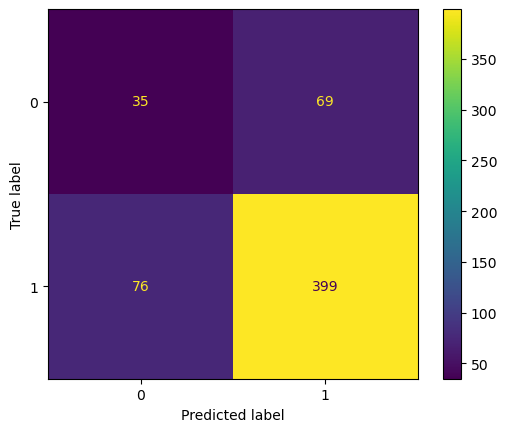

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices